In [1]:
import pandas as pd
import matplotlib.colors as mcolors
import colorsys
import itertools
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from heatindex import heatindex
from tqdm import tqdm
# !pip install geopy
import itertools
tqdm.pandas()
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [34]:
# outdoor_temp = pd.read_csv('./tagged_data_archived/outdoor_sen_meta_tagged_temperature.csv') 
# outdoor_temp = pd.read_csv('outdoor_heat.csv')
outdoor_temp = pd.read_csv('./2023_11_20/outdoor_temp_meta_tagged.csv')

figure_directory = 'paper_plots'

# Convert 'Date/Time' to datetime format
outdoor_temp['Date/Time'] = pd.to_datetime(outdoor_temp['Date/Time'])

# Set 'Date/Time' as the index
outdoor_temp.set_index('Date/Time', inplace=True)

outdoor_temp['Hour'] = outdoor_temp.index.hour

# Humidity data
outdoor_hum = pd.read_csv('./2023_11_20/outdoor_hum_meta_tagged.csv')

# Convert 'Date/Time' to datetime format
outdoor_hum['Date/Time'] = pd.to_datetime(outdoor_hum['Date/Time'])

# Set 'Date/Time' as the index
outdoor_hum.set_index('Date/Time', inplace=True)

outdoor_hum['Hour'] = outdoor_hum.index.hour

# Now you can safely round the index and extract the hour
outdoor_temp['Original_Outdoor_Time'] = outdoor_temp.index.round('H').hour

/tmp/ipykernel_135/536577204.py:3: DtypeWarning: Columns (9,11,14,15,16,18,20,21,22,25,26,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  outdoor_temp = pd.read_csv('./2023_11_20/outdoor_temp_meta_tagged.csv')
/tmp/ipykernel_135/536577204.py:16: DtypeWarning: Columns (15,16,17,22,25,26,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  outdoor_hum = pd.read_csv('./2023_11_20/outdoor_hum_meta_tagged.csv')


In [3]:
site_type = {'AD': ['Asylum Down', 'Commercial/\nbusiness/\nindustrial','blue'],
             'ASH' : ['Ashaiman', 'Medium/low-density\nresidential', 'tab:orange'],
             'EL': ['East Legon', 'Medium/low-density\nresidential', 'tab:orange'],
             'JT' : ['James Town', 'High-density\nresidential', 'red'],
             'LA': ['Labadi', 'Medium/low-density\nresidential', 'tab:orange'],
             'N1W': ['N1 West Motorway', 'Commercial/\nbusiness/\nindustrial','blue'],
             'NM': ['Nima', 'High-density\nresidential', 'red'],
             'TF': ['Taifa','Medium/low-density\nresidential', 'tab:orange'],
             'TMW': ['Tema Motorway', 'Commercial/\nbusiness/\nindustrial','blue'],
             'UGH': ['University of Ghana', 'Peri-urban background', 'green']}

land_use_type = {'low-dens' : 'Medium/low-density residential', 'high-dens': 'High-density residential', 'commercial': 'Commercial/business/industrial', 'other': 'Peri-urban background' }

In [4]:
# Group by 'sensor_id' and calculate the number of unique 'site_id's for each 'sensor_id'
unique_site_ids_per_sensor = outdoor_temp.groupby('sensor_id')['site_id'].nunique()

# Check if any 'sensor_id' is associated with more than one 'site_id'
multiple_sites_per_sensor = unique_site_ids_per_sensor[unique_site_ids_per_sensor > 1]

if len(multiple_sites_per_sensor) > 0:
    print("These sensor_ids are associated with multiple site_ids:")
    print(multiple_sites_per_sensor)
else:
    print("Every sensor_id is associated with a unique site_id.")


These sensor_ids are associated with multiple site_ids:
sensor_id
'6C90'    2
'8EF2'    2
Name: site_id, dtype: int64


In [33]:
outdoor_temp['Hour']

Date/Time
2023-04-03 07:45:00     7
2023-04-03 07:55:00     7
2023-04-03 08:05:00     8
2023-04-03 08:15:00     8
2023-04-03 08:25:00     8
                       ..
2023-03-01 06:05:00     6
2023-03-01 07:10:00     7
2023-03-01 08:15:00     8
2023-03-01 09:20:00     9
2023-03-01 10:25:00    10
Name: Hour, Length: 1271533, dtype: int32

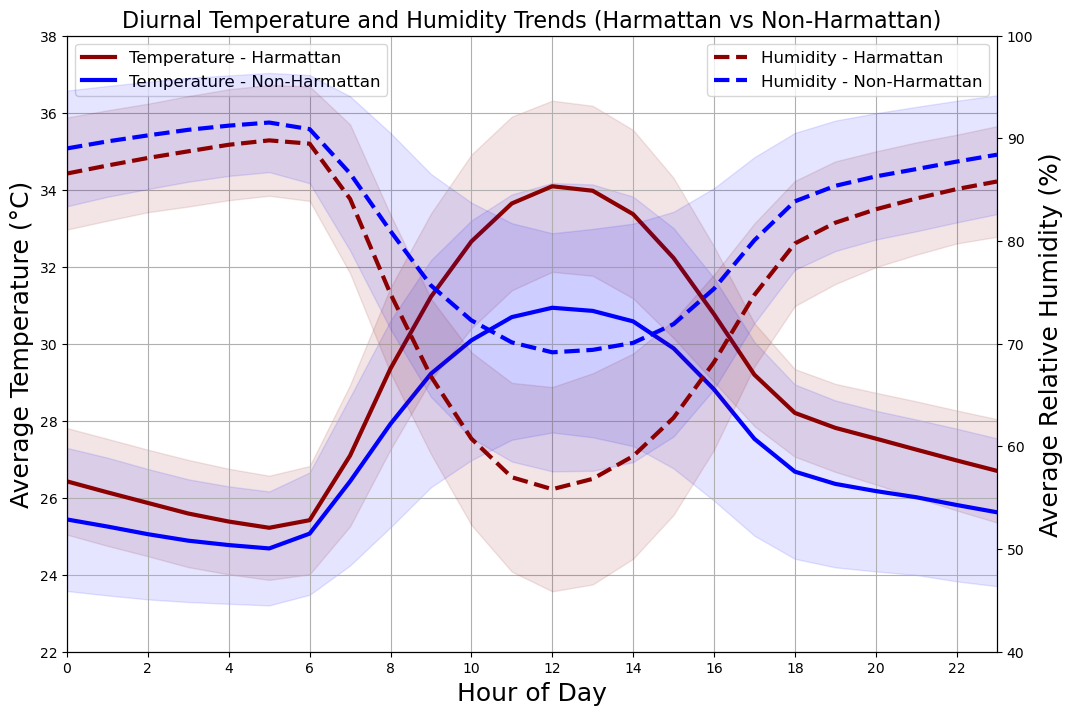

In [4]:
import matplotlib.pyplot as plt

# # Define the season based on the month and add it as a new column in both dataframes
# def define_season(dt):
#     if dt.month in [11, 12, 1, 2]:
#         return 'Harmattan'
#     else:
#         return 'Non-Harmattan'

# outdoor_temp['Season'] = outdoor_temp.index.month.map(define_season)
# outdoor_hum['Season'] = outdoor_hum.index.month.map(define_season)

# Define the season and add it as a new column
outdoor_temp['Season'] = outdoor_temp.index.month.map({11: 'Harmattan', 12: 'Harmattan', 1: 'Harmattan', 2: 'Harmattan',3: 'Harmattan'}).fillna('Non-Harmattan')

# Define the season and add it as a new column
outdoor_hum['Season'] = outdoor_hum.index.month.map({11: 'Harmattan', 12: 'Harmattan', 1: 'Harmattan', 2: 'Harmattan',3: 'Harmattan',}).fillna('Non-Harmattan')


# Define the color maps for temperature and humidity
temp_color_map = {'Harmattan': 'darkred', 'Non-Harmattan': 'blue'}
# hum_color_map = {'Harmattan': 'lightcoral', 'Non-Harmattan': 'lightblue'}
hum_color_map = temp_color_map

# Group the temperature data
temp_grouped = outdoor_temp.groupby(['Season', 'Hour'])['Value'].agg(['mean', 'std']).reset_index()

# Group the humidity data
hum_grouped = outdoor_hum.groupby(['Season', 'Hour'])['Value'].agg(['mean', 'std']).reset_index()

plt.figure(figsize=(12, 8))

# Create the primary axis for temperature
ax_temp = plt.gca()

for season in temp_grouped['Season'].unique():
    season_data = temp_grouped[temp_grouped['Season'] == season]
    ax_temp.plot(season_data['Hour'], season_data['mean'], label=f'Temperature - {season}', color=temp_color_map[season], lw=3)
    ax_temp.fill_between(season_data['Hour'], season_data['mean'] - season_data['std'], season_data['mean'] + season_data['std'], color=temp_color_map[season], alpha=0.1)

# Create the secondary axis for humidity
ax_hum = ax_temp.twinx()

for season in hum_grouped['Season'].unique():
    season_data = hum_grouped[hum_grouped['Season'] == season]
    ax_hum.plot(season_data['Hour'], season_data['mean'], label=f'Humidity - {season}', color=hum_color_map[season], lw=3, linestyle='--')
    ax_hum.fill_between(season_data['Hour'], season_data['mean'] - season_data['std'], season_data['mean'] + season_data['std'], color=hum_color_map[season], alpha=0.1)

# Set labels and title
ax_temp.set_xlabel('Hour of Day', fontsize=18)
ax_temp.set_ylabel('Average Temperature (°C)', fontsize=18)
ax_hum.set_ylabel('Average Relative Humidity (%)', fontsize=18)
plt.title('Diurnal Temperature and Humidity Trends (Harmattan vs Non-Harmattan)', fontsize=16)

# Set limits and ticks
ax_temp.set_xlim(0, 23)
ax_temp.set_ylim(22, 38)
ax_hum.set_ylim(40, 100)
plt.xticks(range(0, 24, 2))

# Add legends
temp_legend = ax_temp.legend(loc='upper left', fontsize=12)
hum_legend = ax_hum.legend(loc='upper right', fontsize=12)

# Add grid
ax_temp.grid(True)

plt.savefig(figure_directory+'/diurnal_temp_humidity_plot_harmattan.png', facecolor='white', bbox_inches='tight')
plt.show()

In [25]:
ndvi_values = pd.read_csv('updated_sites_lat_long_ndvi.csv')
ndbi_values = pd.read_csv('updated_sites_lat_long_ndbi.csv')


In [31]:
# Merge the dataframes
# outdoor_temp = pd.merge(outdoor_temp, ndvi_values[['site_id','mean_ndvi']], 
#                           on='site_id')
# outdoor_temp = pd.merge(outdoor_temp, ndbi_values[['site_id','mean_ndbi']], 
#                           on='site_id')


In [34]:
outdoor_temp.head()

,Unit,Value,sensor_id,site_id,file,record_id,redcap_repeat_instrument,redcap_repeat_instance,neighbourhood_id(ORIGINAL),neighbourhood_id,...,Lon,site_type,Road_surface,pop_dens,WB_cat,ndvi,pop_dens_cat,ndvi_cat,Hour,Original_Outdoor_Time
Date/Time,,,,,,,,,,,,,,,,,,,,,
2023-04-03 07:45:00,C,31.0,'6815',ASH,data_in/Outdoor_Data/Temperature_Data/ASH_2023...,155.0,NaN,NaN,ASH,ASH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,8
2023-04-03 07:55:00,C,30.0,'6815',ASH,data_in/Outdoor_Data/Temperature_Data/ASH_2023...,155.0,NaN,NaN,ASH,ASH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,8
2023-04-03 08:05:00,C,30.0,'6815',ASH,data_in/Outdoor_Data/Temperature_Data/ASH_2023...,155.0,NaN,NaN,ASH,ASH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,8
2023-04-03 08:15:00,C,30.0,'6815',ASH,data_in/Outdoor_Data/Temperature_Data/ASH_2023...,155.0,NaN,NaN,ASH,ASH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,8
2023-04-03 08:25:00,C,30.5,'6815',ASH,data_in/Outdoor_Data/Temperature_Data/ASH_2023...,155.0,NaN,NaN,ASH,ASH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,8


In [35]:
# indoor_temp = pd.read_csv('./tagged_data_no_threshold/indoor_sen_meta_tagged.csv') 
indoor_temp = pd.read_csv('./2023_11_20/indoor_temp_meta_tagged.csv')
indoor_temp['Date/Time'] = pd.to_datetime(indoor_temp['Date/Time'])
indoor_temp.set_index('Date/Time', inplace=True)
common_sites = set(indoor_temp['site_id']).intersection(set(outdoor_temp['site_id']))

/tmp/ipykernel_135/1711354370.py:2: DtypeWarning: Columns (12,22,30,32,33,41,43,60,103,104,107,108,109,112,115,116) have mixed types. Specify dtype option on import or set low_memory=False.
  indoor_temp = pd.read_csv('./2023_11_20/indoor_temp_meta_tagged.csv')


RangeIndex(start=0, stop=1199574, step=1)

In [36]:
# Rename 'Value' column in indoor dataframe to avoid confusion after merge
indoor_temp.rename(columns={'Value': 'Indoor_Value', 'sensor_id': 'indoor_sensor_id', 'redcap_repeat_instance_x' : 'redcap_x', 'record_id_x': 'record_x', 'redcap_repeat_instrument_x': 'redcap_instrument_x'}, inplace=True)

indoor_temp['Original_Indoor_Time'] = indoor_temp.index.round('H').hour
# outdoor_temp['Original_Outdoor_Time'] = outdoor_temp.index.round('H').hour

# Sort both dataframes by 'Date/Time' and 'site_id'
outdoor_temp.sort_values(['Date/Time', 'site_id'], inplace=True)
indoor_temp.sort_values(['Date/Time', 'site_id'], 
                        inplace=True)

# Merge the dataframes
merged_df = pd.merge_asof(indoor_temp, outdoor_temp, 
                          on='Date/Time', by='site_id', 
                          tolerance=pd.Timedelta('1 hour'), direction='nearest', suffixes = ('_outdoor', '_indoor'))

merged_df['Temp_diff'] = merged_df['Indoor_Value'] - merged_df['Value']
merged_df['Date/Time'] = pd.to_datetime(merged_df['Date/Time'])
merged_df['Day/night'] = merged_df['Date/Time'].dt.hour.apply(lambda x: 'Day' if 6 <= x < 18 else 'Night')


In [37]:
# Assuming merged_df and ndvi_values are already loaded as described
# Convert 'site_id' to string if not already (in both dataframes)
merged_df['site_id'] = merged_df['site_id'].astype(str)
ndvi_values['site_id'] = ndvi_values['site_id'].astype(str)
ndbi_values['site_id'] = ndbi_values['site_id'].astype(str)

# Merge NDVI values with merged_df
merged_df = pd.merge(merged_df, ndvi_values[['site_id', 'mean_ndvi']], on='site_id', how='left')
# Merge NDVI values with merged_df
merged_df = pd.merge(merged_df, ndbi_values[['site_id', 'mean_ndbi']], on='site_id', how='left')

# Now merged_df contains the NDVI values along with other data


In [41]:
# Assuming your dataframe has a datetime column named "timestamp"
merged_df['Date'] = merged_df['Date/Time'].dt.date

# Step 1: Day-Level Aggregation with 'site_type_outdoor'
day_level = merged_df.groupby(['indoor_sensor_id', 'Date', 'Day/night']).agg(
    daily_mean_indoor=('Indoor_Value', 'mean'),
    daily_mean_outdoor=('Value', 'mean'),
    daily_max_indoor=('Indoor_Value', 'max'),
    daily_max_outdoor=('Value', 'max'),
    site_type_outdoor=('site_type_outdoor', 'first'),  # Assuming each sensor_id, Date, Day/night combo has a single site type
    mean_ndvi=('mean_ndvi', 'first'),  # Assuming each sensor_id, Date, Day/night combo has a single site type
    mean_ndbi=('mean_ndbi', 'first')  # Assuming each sensor_id, Date, Day/night combo has a single site type
).reset_index()

# Step 2: Sensor-Level Aggregation
aggregated_data = day_level.groupby(['indoor_sensor_id', 'Day/night']).agg(
    average_daily_mean_indoor=('daily_mean_indoor', 'mean'),
    average_daily_mean_outdoor=('daily_mean_outdoor', 'mean'),
    average_daily_max_indoor=('daily_max_indoor', 'mean'),
    average_daily_max_outdoor=('daily_max_outdoor', 'mean'),
    mean_ndvi=('mean_ndvi', 'first'),
    mean_ndbi=('mean_ndbi', 'first')
).reset_index()

/tmp/ipykernel_2481/3629877474.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


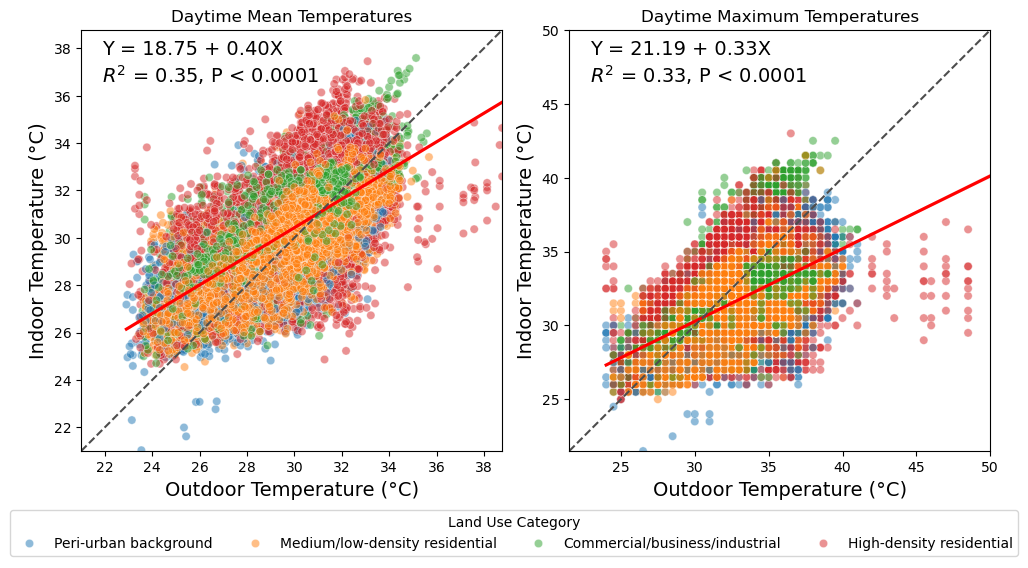

In [39]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Function to annotate fit
def annotate_fit(x, y, ax):
    # Drop NaN values
    df = pd.DataFrame({'x': x, 'y': y}).dropna()
    X = sm.add_constant(df['x'])
    model = sm.OLS(df['y'], X).fit()
    a, b = model.params['const'], model.params['x']
    r2 = model.rsquared
    p_value_slope = model.pvalues['x']
    if p_value_slope < 0.0001:
        p_text = "P < 0.0001"
    else:
        p_text = f"P = {p_value_slope:.4f}"
    ax.annotate(f'Y = {a:.2f} + {b:.2f}X\n$R^2$ = {r2:.2f}, {p_text}', xy=(0.05, 0.875), xycoords='axes fraction', fontsize=14)

# Choose either 'day_level' or 'aggregated_data' for analysis
analysis_level = 'day_level'  # Set to either 'day' or 'aggregated'

if analysis_level == 'day_level':
    analysis_frame = day_level
    axis_prefix = 'Daily'
elif analysis_level == 'aggregated':
    analysis_frame = aggregated_data
    axis_prefix = 'Average Daily'

# Convert site types to labels
analysis_frame['site_type_outdoor'] = analysis_frame['site_type_outdoor'].map(land_use_type)

day_night = 'Day'  # Change as needed

plt.figure(figsize=(10, 10))  # Adjusted for a square plot

# Helper function to find the common limits
def find_common_limits(series1, series2, upper_bound=None):
    combined = pd.concat([series1, series2], ignore_index=True)
    lower = combined.min()
    upper = combined.max()
    if upper_bound is not None:
        upper = min(upper, upper_bound)
    return lower, upper
    
# Find the common limits for mean temperatures
mean_limits = find_common_limits(analysis_frame[axis_prefix.lower().replace(' ','_')+'_mean_outdoor'], 
                                 analysis_frame[axis_prefix.lower().replace(' ','_')+'_mean_indoor'])

# Mean average temperatures
ax1 = plt.subplot(121)
# Use sns.scatterplot() instead of sns.regplot() for hue
sns.scatterplot(data=analysis_frame[analysis_frame['Day/night'] == day_night], 
                x=axis_prefix.lower().replace(' ','_')+'_mean_outdoor', 
                y=axis_prefix.lower().replace(' ','_')+'_mean_indoor',
                hue='site_type_outdoor',
                # palette='viridis',
                alpha=0.5,
                legend="full",
                ax=ax1)
sns.regplot(data=analysis_frame[analysis_frame['Day/night'] == day_night], 
            x=axis_prefix.lower().replace(' ','_')+'_mean_outdoor', 
            y=axis_prefix.lower().replace(' ','_')+'_mean_indoor', 
            ax=ax1, 
            scatter = False,
            # scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red'}, 
            ci=95)
ax1.set_xlim(mean_limits)
ax1.set_ylim(mean_limits)
ax1.set_aspect('equal')
ax1.plot(mean_limits, mean_limits, ls="--", c=".3")  # x=y line
ax1.set_title(f'{day_night}time Mean Temperatures')
ax1.set_ylabel('Indoor Temperature (°C)', fontsize = 14)
ax1.set_xlabel('Outdoor Temperature (°C)', fontsize = 14)
annotate_fit(analysis_frame[axis_prefix.lower().replace(' ','_')+'_mean_outdoor'], analysis_frame[axis_prefix.lower().replace(' ','_')+'_mean_indoor'], ax1)

if day_night == 'Day':
    max_limits = find_common_limits(analysis_frame[axis_prefix.lower().replace(' ','_')+'_max_outdoor'], 
                                    analysis_frame[axis_prefix.lower().replace(' ','_')+'_max_indoor'],
                                    upper_bound=50)  # Set upper bound to 50

    # Mean maximum temperatures
    ax2 = plt.subplot(122)
    sns.scatterplot(data=analysis_frame[analysis_frame['Day/night'] == day_night], 
                x=axis_prefix.lower().replace(' ','_')+'_max_outdoor', 
                y=axis_prefix.lower().replace(' ','_')+'_max_indoor',
                hue='site_type_outdoor',
                # palette='viridis',
                alpha = 0.5,
                legend=False,
                ax=ax2)
    sns.regplot(data=analysis_frame[analysis_frame['Day/night'] == day_night], 
                x=axis_prefix.lower().replace(' ','_')+'_max_outdoor', 
                y=axis_prefix.lower().replace(' ','_')+'_max_indoor', 
                ax=ax2, 
                # scatter_kws={'alpha': 0.5}, 
                scatter = False,
                line_kws={'color': 'red'}, 
                ci=95)
    ax2.set_xlim(max_limits)
    ax2.set_ylim(max_limits)
    ax2.set_aspect('equal')
    ax2.plot(max_limits, max_limits, ls="--", c=".3")  # x=y line
    ax2.set_title(f'{day_night}time Maximum Temperatures')
    ax2.set_ylabel('Indoor Temperature (°C)', fontsize = 14)
    ax2.set_xlabel('Outdoor Temperature (°C)', fontsize = 14)
    annotate_fit(analysis_frame[axis_prefix.lower().replace(' ','_')+'_max_outdoor'], analysis_frame[axis_prefix.lower().replace(' ','_')+'_max_indoor'], ax2)

# After all plotting commands:
# Obtain the handles and labels from one of the scatterplots (either ax1 or ax2)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend_.remove()
# # Create a custom legend for the entire figure using ax.legend()
# ax1.legend(handles=handles, labels=labels, title='Land Use Category', 
#            loc='upper center', bbox_to_anchor=(0.5, -0.15), 
#            ncol=len(labels), fontsize='small')
# Create a new axis for the legend at the bottom
legend_ax = plt.gcf().add_axes([0.15, 0.05, 0.7, 0.05], frame_on=False)  # Adjust the values if necessary
legend_ax.axis('off')

# Create a custom legend for the entire figure using legend_ax.legend()
legend_ax.legend(handles=handles, labels=labels, title='Land Use Category',
                 loc='center', ncol=len(labels), fontsize='medium')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=-0.25)  # Provide space at the bottom for the legend

plt.savefig(f"{figure_directory}/{analysis_level}_{day_night}_correlation_indoor_outdoor.png", bbox_inches='tight')


In [43]:
import statsmodels.api as sm

x = aggregated_data['mean_ndvi']
y = aggregated_data['average_daily_mean_outdoor']

print(x.corr(y))


-0.11617511307877659


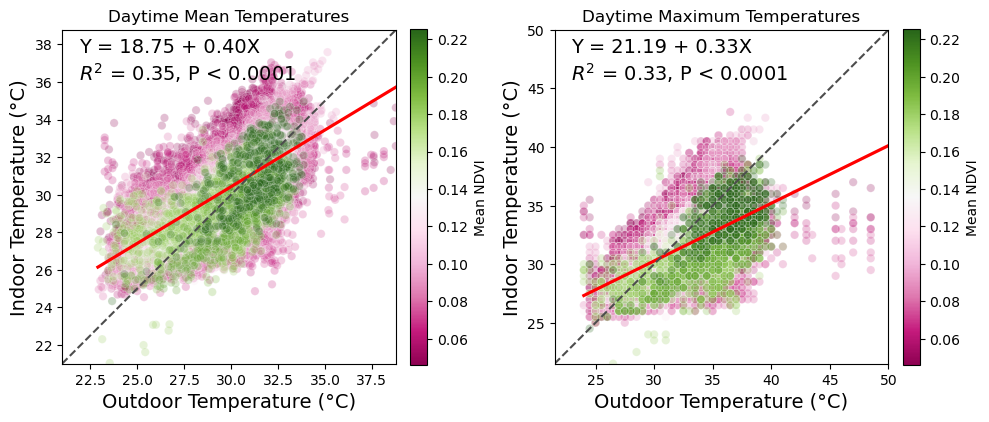

In [41]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Function to annotate fit
def annotate_fit(x, y, ax):
    # Drop NaN values
    df = pd.DataFrame({'x': x, 'y': y}).dropna()
    X = sm.add_constant(df['x'])
    model = sm.OLS(df['y'], X).fit()
    a, b = model.params['const'], model.params['x']
    r2 = model.rsquared
    p_value_slope = model.pvalues['x']
    if p_value_slope < 0.0001:
        p_text = "P < 0.0001"
    else:
        p_text = f"P = {p_value_slope:.4f}"
    ax.annotate(f'Y = {a:.2f} + {b:.2f}X\n$R^2$ = {r2:.2f}, {p_text}', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=14)

# Choose either 'day_level' or 'aggregated_data' for analysis
analysis_level = 'day_level'  # Set to either 'day' or 'aggregated'

if analysis_level == 'day_level':
    analysis_frame = day_level
    axis_prefix = 'Daily'
elif analysis_level == 'aggregated':
    analysis_frame = aggregated_data
    axis_prefix = 'Average Daily'

# # Convert site types to labels
# analysis_frame['site_type_outdoor'] = analysis_frame['site_type_outdoor'].map(land_use_type)

day_night = 'Day'  # Change as needed

# Sort the analysis_frame by 'mean_ndvi'
analysis_frame = analysis_frame.sort_values('mean_ndvi')

plt.figure(figsize=(10, 10))  # Adjusted for a square plot

# Helper function to find the common limits
def find_common_limits(series1, series2, upper_bound=None):
    combined = pd.concat([series1, series2], ignore_index=True)
    lower = combined.min()
    upper = combined.max()
    if upper_bound is not None:
        upper = min(upper, upper_bound)
    return lower, upper
    
# Find the common limits for mean temperatures
mean_limits = find_common_limits(analysis_frame[axis_prefix.lower().replace(' ','_')+'_mean_outdoor'], 
                                 analysis_frame[axis_prefix.lower().replace(' ','_')+'_mean_indoor'])

# # Custom colormap for NDVI
# cmap = sns.light_palette("green", as_cmap=True)


# Mean average temperatures - modified to color by mean_ndvi
ax1 = plt.subplot(121)
sns.scatterplot(
    data=analysis_frame[analysis_frame['Day/night'] == day_night], 
    x=axis_prefix.lower().replace(' ','_')+'_mean_outdoor', 
    y=axis_prefix.lower().replace(' ','_')+'_mean_indoor',
    hue='mean_ndvi',  # Color by mean NDVI value
    # palette=cmap,
    palette='PiYG',
    alpha=0.25,
    legend=False,  # Temporarily disable legend
    ax=ax1
)

# Add colorbar for NDVI
smc = plt.cm.ScalarMappable(cmap='PiYG', norm=plt.Normalize(vmin=analysis_frame['mean_ndvi'].min(), vmax=analysis_frame['mean_ndvi'].max()))
smc.set_array([])
cbar = plt.colorbar(smc, ax=ax1,fraction=0.046, pad=0.04)
cbar.set_label('Mean NDVI')

sns.regplot(data=analysis_frame[analysis_frame['Day/night'] == day_night], 
            x=axis_prefix.lower().replace(' ','_')+'_mean_outdoor', 
            y=axis_prefix.lower().replace(' ','_')+'_mean_indoor', 
            ax=ax1, 
            scatter = False,
            # scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red'}, 
            ci=95)
ax1.set_xlim(mean_limits)
ax1.set_ylim(mean_limits)
ax1.set_aspect('equal')
ax1.plot(mean_limits, mean_limits, ls="--", c=".3")  # x=y line
ax1.set_title(f'{day_night}time Mean Temperatures')
ax1.set_ylabel('Indoor Temperature (°C)', fontsize = 14)
ax1.set_xlabel('Outdoor Temperature (°C)', fontsize = 14)
annotate_fit(analysis_frame[axis_prefix.lower().replace(' ','_')+'_mean_outdoor'], analysis_frame[axis_prefix.lower().replace(' ','_')+'_mean_indoor'], ax1)

if day_night == 'Day':
    max_limits = find_common_limits(analysis_frame[axis_prefix.lower().replace(' ','_')+'_max_outdoor'], 
                                    analysis_frame[axis_prefix.lower().replace(' ','_')+'_max_indoor'],
                                    upper_bound=50)  # Set upper bound to 50

    # Mean maximum temperatures
    ax2 = plt.subplot(122)
    sns.scatterplot(data=analysis_frame[analysis_frame['Day/night'] == day_night], 
                x=axis_prefix.lower().replace(' ','_')+'_max_outdoor', 
                y=axis_prefix.lower().replace(' ','_')+'_max_indoor',
                hue='mean_ndvi',  # Color by mean NDVI value
                # palette=cmap,
                palette='PiYG',
                alpha=0.25,
                legend=False,  # Temporarily disable legend
                ax=ax2)
    # Add colorbar for NDVI
    smc2 = plt.cm.ScalarMappable(cmap='PiYG', norm=plt.Normalize(vmin=analysis_frame['mean_ndvi'].min(), vmax=analysis_frame['mean_ndvi'].max()))
    smc2.set_array([])
    cbar2 = plt.colorbar(smc2, ax=ax2,fraction=0.046, pad=0.04)
    cbar2.set_label('Mean NDVI')
    sns.regplot(data=analysis_frame[analysis_frame['Day/night'] == day_night], 
                x=axis_prefix.lower().replace(' ','_')+'_max_outdoor', 
                y=axis_prefix.lower().replace(' ','_')+'_max_indoor', 
                ax=ax2, 
                # scatter_kws={'alpha': 0.5}, 
                scatter = False,
                line_kws={'color': 'red'}, 
                ci=95)
    ax2.set_xlim(max_limits)
    ax2.set_ylim(max_limits)
    ax2.set_aspect('equal')
    ax2.plot(max_limits, max_limits, ls="--", c=".3")  # x=y line
    ax2.set_title(f'{day_night}time Maximum Temperatures')
    ax2.set_ylabel('Indoor Temperature (°C)', fontsize = 14)
    ax2.set_xlabel('Outdoor Temperature (°C)', fontsize = 14)
    annotate_fit(analysis_frame[axis_prefix.lower().replace(' ','_')+'_max_outdoor'], analysis_frame[axis_prefix.lower().replace(' ','_')+'_max_indoor'], ax2)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=-0.25)  # Provide space at the bottom for the legend

plt.savefig(f"{figure_directory}/{analysis_level}_{day_night}_correlation_indoor_outdoor_ndvi.png", bbox_inches='tight')


In [42]:
# Define the hours for daytime and nighttime
daytime_hours = list(range(6, 18))
nighttime_hours = list(range(18, 24)) + list(range(0, 6))


# Extracting the date from the timestamp
outdoor_temp['Date'] = outdoor_temp.index.date

# For each site, for each day, calculate mean of daytime and nighttime heat indices, and max of daytime heat indices
daily_heat_metrics = outdoor_temp.groupby(['site_id', 'Date']).progress_apply(lambda group: pd.Series({
    'daily_avg_daytime_temperature': group[group['Hour'].isin(daytime_hours)]['Value'].mean(),
    'daily_avg_nighttime_temperature': group[group['Hour'].isin(nighttime_hours)]['Value'].mean(),
    'daily_max_daytime_temperature': group[group['Hour'].isin(daytime_hours)]['Value'].max()
}))

# Now, average these daily heat metrics over all days for each site
aggregated_heat_data = daily_heat_metrics.groupby('site_id').mean().reset_index()

# You don't need to merge distances here again if you already did it with temperature data, 
# unless you want this to be a standalone DataFrame.
# aggregated_heat_data = aggregated_heat_data.merge(outdoor_temp[['site_id', 'distance']].drop_duplicates(), on='site_id', how='left')
aggregated_heat_data.set_index('site_id', inplace=True)  # Set the site_id back as the index

# Sort the sites by the chosen method
sort_by_heat = 'daily_avg_daytime_temperature'  # or any other column you prefer
sorted_heat_sites = aggregated_heat_data.sort_values(sort_by_heat)


100%|███████████████████████████████████| 40337/40337 [00:32<00:00, 1231.07it/s]


100%|█████████████████████████████████████████| 140/140 [00:11<00:00, 11.79it/s]


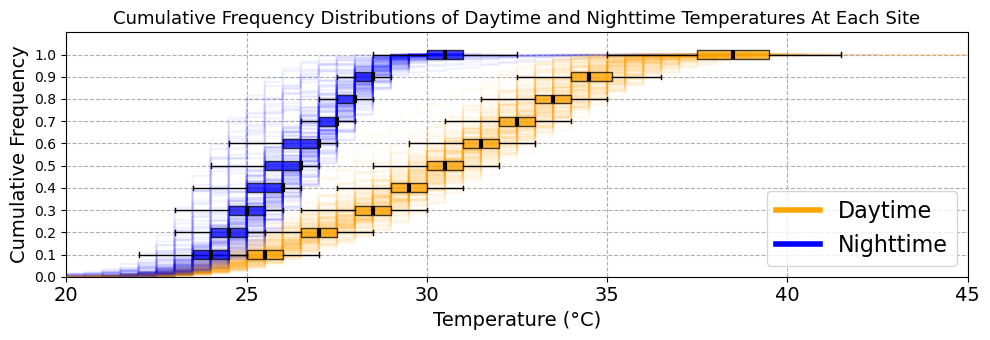

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate a normalized cumulative sum
def compute_cdf(data):
    sorted_data = np.sort(data)
    cumdist = np.linspace(0., 1., len(sorted_data))
    return sorted_data, cumdist

# Function to retrieve temperature at a given percentile
def get_temperature_at_percentile(sorted_data, cumdist, percentile):
    return np.interp(percentile, cumdist, sorted_data)

# # Define the heat index categories
# heat_ranges =  [27, 33, 39, 46]
# heat_categories = ['Minimal', 'Low', 'Moderate', 'High', 'Extreme']

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 3.5))

daytime_percentile_data = {perc: [] for perc in np.arange(0.1, 1.1, 0.1)}
nighttime_percentile_data = {perc: [] for perc in np.arange(0.1, 1.1, 0.1)}

# Dummy lines for legend
line1, = ax.plot([], [], color='orange', linewidth=4)
line2, = ax.plot([], [], color='blue', linewidth=4)

# Iterate over sites and plot the CDFs
for site in tqdm(sorted_heat_sites.index):
    daytime_values = outdoor_temp[(outdoor_temp['site_id'] == site) & (outdoor_temp['Hour'].isin(daytime_hours))]['Value'].values
    nighttime_values = outdoor_temp[(outdoor_temp['site_id'] == site) & (outdoor_temp['Hour'].isin(nighttime_hours))]['Value'].values

    # Filter out nan values
    daytime_values = daytime_values[~np.isnan(daytime_values)]
    nighttime_values = nighttime_values[~np.isnan(nighttime_values)]

    # If there's no data left after filtering, continue to the next site
    if len(daytime_values) == 0 or len(nighttime_values) == 0:
        continue

# Compute CDF for daytime temperatures of this site
    sorted_daytime, cumdist_daytime = compute_cdf(daytime_values)
    ax.plot(sorted_daytime, cumdist_daytime, color='orange', alpha=0.05)
    
    # Compute CDF for nighttime temperatures of this site
    sorted_nighttime, cumdist_nighttime = compute_cdf(nighttime_values)
    ax.plot(sorted_nighttime, cumdist_nighttime, color='blue', alpha=0.05)

    # Retrieve temperature values at each 10th percentile
    for perc in np.arange(0.1, 1.1, 0.1):
        daytime_temp = get_temperature_at_percentile(sorted_daytime, cumdist_daytime, perc)
        nighttime_temp = get_temperature_at_percentile(sorted_nighttime, cumdist_nighttime, perc)
        daytime_percentile_data[perc].append(daytime_temp)
        nighttime_percentile_data[perc].append(nighttime_temp)

# Boxplot properties
medianprops = dict(linestyle='-', linewidth=3, color='black')

# Plot boxplots for daytime and nighttime data at each 10th percentile
for perc, daytime_values in daytime_percentile_data.items():
    ax.boxplot(daytime_values, positions=[perc], widths=0.04, vert=False, patch_artist=True, boxprops=dict(facecolor="orange", alpha=0.75), medianprops=medianprops, showfliers=False)

for perc, nighttime_values in nighttime_percentile_data.items():
    ax.boxplot(nighttime_values, positions=[perc], widths=0.04, vert=False, patch_artist=True, boxprops=dict(facecolor="blue", alpha=0.75), medianprops=medianprops, showfliers=False)

# Add the vertical lines and labels
# for index, heat_range in enumerate(heat_ranges):
#     ax.axvline(heat_range, color='red', linestyle='--', linewidth=1.2)
#     prev_range = heat_ranges[index-1] if index > 0 else 0
#     midpoint = (prev_range + heat_range) / 2
#     y_position = 1.025
#     if index == 0:
#         ax.text(22, y_position, heat_categories[index], horizontalalignment='left', fontsize=12, color='red')
#     else:
#         ax.text(midpoint, y_position, heat_categories[index], horizontalalignment='center', fontsize=12, color='red')

# last_range = heat_ranges[-1]
# # max_x = ax.get_xlim()[1]
# # midpoint = (last_range + max_x) / 2
# ax.text(55, 1.025, heat_categories[-1], horizontalalignment='center', fontsize=12, color='red')

# Add labels, title, legend, etc.
ax.set_xlabel('Temperature (°C)', fontsize = 14)
ax.set_ylabel('Cumulative Frequency', fontsize = 14)
ax.set_title('Cumulative Frequency Distributions of Daytime and Nighttime Temperatures At Each Site', fontsize = 13)
ax.legend([line1, line2], ['Daytime', 'Nighttime'], loc='lower right', fontsize=16)

# Adjust y-axis settings
ax.set_ylim([0, 1.1])  # Update the y-axis limit
ax.set_xlim([20, 45])  # Update the x-axis limit
ax.set_yticks(np.arange(0, 1.1, 0.1))  
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())  # Fix y-axis tick formatting

# Grid and show
plt.grid(True, which="both", ls="--")
plt.xticks(fontsize = 14)
# plt.ticks(fontsize = 14)
plt.tight_layout()
plt.savefig(figure_directory+'/CMF_outdoor_temperatures.png', bbox_inches='tight')


In [12]:
# dwelling_variables = ['dwelling_type', 'roof_material', 'roof_shape', 'wall_material', 'floor_material', 'ceiling_material', 'roof_wall_gap', 'roof_colour', 'window_type', 'window_type_other', 'window_orientiation_1', 'window_orientation_2', 'number_rooms', 'dwelling_floors', 'shade_trees_yesno', 'shade_buildings_yesno', 'aircon_yesno', 'windows_yesno']
dwelling_variables = ['dwelling_type', 'roof_material', 'roof_shape', 'wall_material', 'floor_material', 'ceiling_material', 'roof_wall_gap', 'roof_colour', 'window_type', 'window_type_other', 'dwelling_floors', 'shade_trees_yesno', 'shade_buildings_yesno', 'aircon_yesno', 'windows_yesno']
for variable in dwelling_variables:
    print(merged_df[variable].value_counts())
    print("\n")

dwelling_type
1.0    379489
4.0    179676
2.0    125865
3.0     81371
5.0      7480
Name: count, dtype: int64


roof_material
4.0    333829
3.0    296889
1.0     87428
6.0     28605
8.0     14114
7.0      7503
2.0      5513
Name: count, dtype: int64


roof_shape
3.0    392642
1.0    366727
Name: count, dtype: int64


wall_material
2.0     672967
7.0      29965
9.0      29570
11.0     22256
10.0      6134
1.0       5802
6.0       1549
Name: count, dtype: int64


floor_material
3.0    410504
2.0    268288
5.0     58516
6.0     28441
Name: count, dtype: int64


ceiling_material
3.0    463299
1.0    136805
2.0     68779
4.0     66725
Name: count, dtype: int64


roof_wall_gap
0.0    659749
1.0     71426
Name: count, dtype: int64


roof_colour
Ash          256400
Silver       104048
Grey          46026
Blue          45663
White         35811
Silver        28923
Red           23496
Brown         20821
Brown         20477
Green         19200
Grey          10172
Black          9817
White       

In [13]:
dwelling_dict = {1: 'Separate house (detached)',
2: 'Semi-detached house',
3: 'Flat/Apartment',
4: 'Compound house (rooms)',
5: 'Huts/buildings (same compound)',
6: 'Wooden structure',
7: 'Metal container',
8: 'Living quarter attached to office/shop',
9: 'Other'}

roof_mat_dict = {
1: 'Cement/Concrete',
2: 'Roofing tiles',
3: 'Metal sheet',
4: 'Slate/Asbestos',
5: 'Bamboo',
6: 'Mud/Mud bricks/Earth',
7: 'Thatch/Palm leaves/Raffia',
8: 'Wood',
9: 'Clay',
10: 'Other'
}

roof_shape_dict = {
1: 'Flat',
2: 'Shallow',
3: 'Pitched',
4: 'Cannot be determined'
}

wall_dict = {
1: 'Burnt bricks',
2: 'Cement blocks/Concrete',
3: 'Landcrete',
4: 'Metal sheet/slate/asbestos',
5: 'Stone',
6: 'Bamboo',
7: 'Mud bricks/earth',
8: 'Palm leaves/thatch/raffia',
9: 'Wood',
10: 'Tile',
11: 'Terrazzo tile',
12: 'Other'
}

floor_dict = {
1: 'Burnt bricks',
2: 'Cement/concrete',
3: 'Ceramic/porcelain/granite/marble tiles',
4: 'Stone',
5: 'Terazzo/terazzo tiles',
6: 'Vinyl tiles',
7: 'Earth/mud',
8: 'Wood',
9: 'Other'
}

ceiling_dict = {
1: 'No ceiling',
2: 'Plaster of Paris',
3: 'Wood',
4: 'TMG',
5: 'Other'
}

window_dict = {
1: 'Plain opening/screen only',
2: 'Shutters',
3: 'Sliding glass',
4: 'Other'}

shade_trees_dict = {1: 'Yes', 0: 'No'}
shade_buildings_dict = {1: 'Yes', 0: 'No'}
roof_gap_dict = {1: 'Yes', 0: 'No'}
aircon_dict = {1: 'Yes', 0: 'No'}
window_yesno = {1: 'Yes', 0: 'No'}

merged_df['dwelling_type'].replace(dwelling_dict, inplace=True)
merged_df['roof_material'].replace(roof_mat_dict, inplace=True)
merged_df['roof_shape'].replace(roof_shape_dict, inplace=True)
merged_df['wall_material'].replace(wall_dict, inplace=True)
merged_df['floor_material'].replace(floor_dict, inplace=True)
merged_df['ceiling_material'].replace(ceiling_dict, inplace=True)
merged_df['roof_wall_gap'].replace(roof_gap_dict, inplace=True)
merged_df['window_type'].replace(window_dict, inplace=True)
merged_df['shade_trees_yesno'].replace(shade_trees_dict, inplace=True)
merged_df['shade_buildings_yesno'].replace(shade_buildings_dict, inplace=True)
merged_df['aircon_yesno'].replace(aircon_dict, inplace=True)
merged_df['windows_yesno'].replace(window_yesno, inplace=True)

# Assuming your dataframe has a datetime column named "timestamp"
merged_df['Date'] = merged_df['Date/Time'].dt.date

# Step 1: Day-Level Aggregation with 'site_type_outdoor'
day_level = merged_df.groupby(['indoor_sensor_id', 'Date', 'Day/night']).agg(
    daily_mean_indoor=('Indoor_Value', 'mean'),
    daily_mean_outdoor=('Value', 'mean'),
    daily_max_indoor=('Indoor_Value', 'max'),
    daily_max_outdoor=('Value', 'max'),
    dwelling_type=('dwelling_type', 'first'),  # assuming consistent for a given sensor and day
    roof_material=('roof_material', 'first'),
    roof_shape=('roof_shape', 'first'),
    roof_colour=('roof_colour', 'first'),
    wall_material=('wall_material', 'first'),
    floor_material=('floor_material', 'first'),
    ceiling_material=('ceiling_material', 'first'),
    roof_wall_gap=('roof_wall_gap', 'first'),
    window_type=('window_type', 'first'),
    dwelling_floors=('dwelling_floors','first'),
    shade_trees_yesno=('shade_trees_yesno', 'first'),
    windows_yesno=('windows_yesno', 'first'),
    aircon_yesno=('aircon_yesno', 'first'),
    site_type_outdoor=('site_type_outdoor', 'first')
).reset_index()

# Calculate temperature difference for each day and night period for each sensor
day_level['Temp_diff'] = day_level['daily_mean_indoor'] - day_level['daily_mean_outdoor']


In [14]:
# Filter data for only daytime
daytime_data = day_level[day_level['Day/night'] == 'Day']

# Compute difference between mean indoor and outdoor temperature for each sensor in daytime
daytime_data['mean_temp_diff'] = daytime_data['daily_mean_indoor'] - daytime_data['daily_mean_outdoor']

# Average this difference for each sensor
avg_diff_data = daytime_data.groupby('indoor_sensor_id')['mean_temp_diff'].mean().reset_index()

dwelling_characteristics = merged_df.drop_duplicates('indoor_sensor_id')[['indoor_sensor_id']+dwelling_variables]

analysis_data = avg_diff_data.merge(dwelling_characteristics, on='indoor_sensor_id', how='left')


/tmp/ipykernel_207/3765622608.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daytime_data['mean_temp_diff'] = daytime_data['daily_mean_indoor'] - daytime_data['daily_mean_outdoor']


In [15]:
import statsmodels.formula.api as smf

# model = smf.ols(formula='mean_temp_diff ~ '+''.join([' + C('+variable+')' for variable in dwelling_variables]), data=analysis_data)

# reg_variables = ['dwelling_type', 'roof_material', 'roof_shape', 'wall_material', 'floor_material', 'ceiling_material', 'roof_wall_gap', 'roof_colour', 'window_type', 'window_type_other', 'dwelling_floors', 'shade_trees_yesno', 'shade_buildings_yesno', 'aircon_yesno', 'windows_yesno']
reg_variables = ['dwelling_type', 'roof_material', 'roof_shape', 'wall_material', 'floor_material', 'ceiling_material', 'roof_wall_gap', 'window_type', 'dwelling_floors', 'shade_trees_yesno', 'shade_buildings_yesno', 'aircon_yesno', 'windows_yesno']
model = smf.ols(formula='mean_temp_diff ~ '+''.join([' + C('+variable+')' for variable in reg_variables]), data=analysis_data)

# model = smf.ols(formula='mean_temp_diff ~ C(wall_material) + C(roof_material) + C(dwelling_type) + C(ceiling_material) + C(roof_wall_gap) + C(dwelling_floors) + C(window_type) + C(windows_yesno) + C(dwelling_floors) + C(shade_trees_yesno) + C(shade_buildings_yesno)', data=analysis_data)

results = model.fit()

# variables = ['wall_material', 'roof_material', 'dwelling_type', 'ceiling_material', 'roof_shape', 'roof_wall_gap']

for variable in reg_variables:
    print("Reference for "+variable+":", merged_df[variable].dropna().sort_values().unique()[0])

print(results.summary())

Reference for dwelling_type: Compound house (rooms)
Reference for roof_material: Cement/Concrete
Reference for roof_shape: Flat
Reference for wall_material: Bamboo
Reference for floor_material: Cement/concrete
Reference for ceiling_material: No ceiling
Reference for roof_wall_gap: No
Reference for window_type: Other
Reference for dwelling_floors: 0.0
Reference for shade_trees_yesno: No
Reference for shade_buildings_yesno: No
Reference for aircon_yesno: No
Reference for windows_yesno: No
                            OLS Regression Results                            
Dep. Variable:         mean_temp_diff   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     2.682
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           0.000584
Time:                        15:12:32   Log-Likelihood:                -96.481
No. Observations:                 

In [17]:
def format_variable_name(name):
    # Removing the prefix 'C(...)[T.' and the closing ']'
    formatted_name = name.replace('C(', '').replace('[T.', ': ').replace(']', '')

    # Splitting into main variable and category, if applicable
    parts = formatted_name.split(': ')
    main_var = parts[0].replace('_', ' ').capitalize()

    # Formatting the category, if it exists
    if len(parts) > 1:
        category = parts[1].replace('_', ' ').capitalize()
        return f"({main_var} {category}"
    else:
        return main_var

# # Applying the function to each variable name
# formatted_variables = [format_variable_name(var) for var in variables]

# print(formatted_variables)


/tmp/ipykernel_207/3661612013.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.errorbar(coefficients[i], y_pos[i], xerr=[[lower_errors[i]], [upper_errors[i]]], fmt='o', color='r')


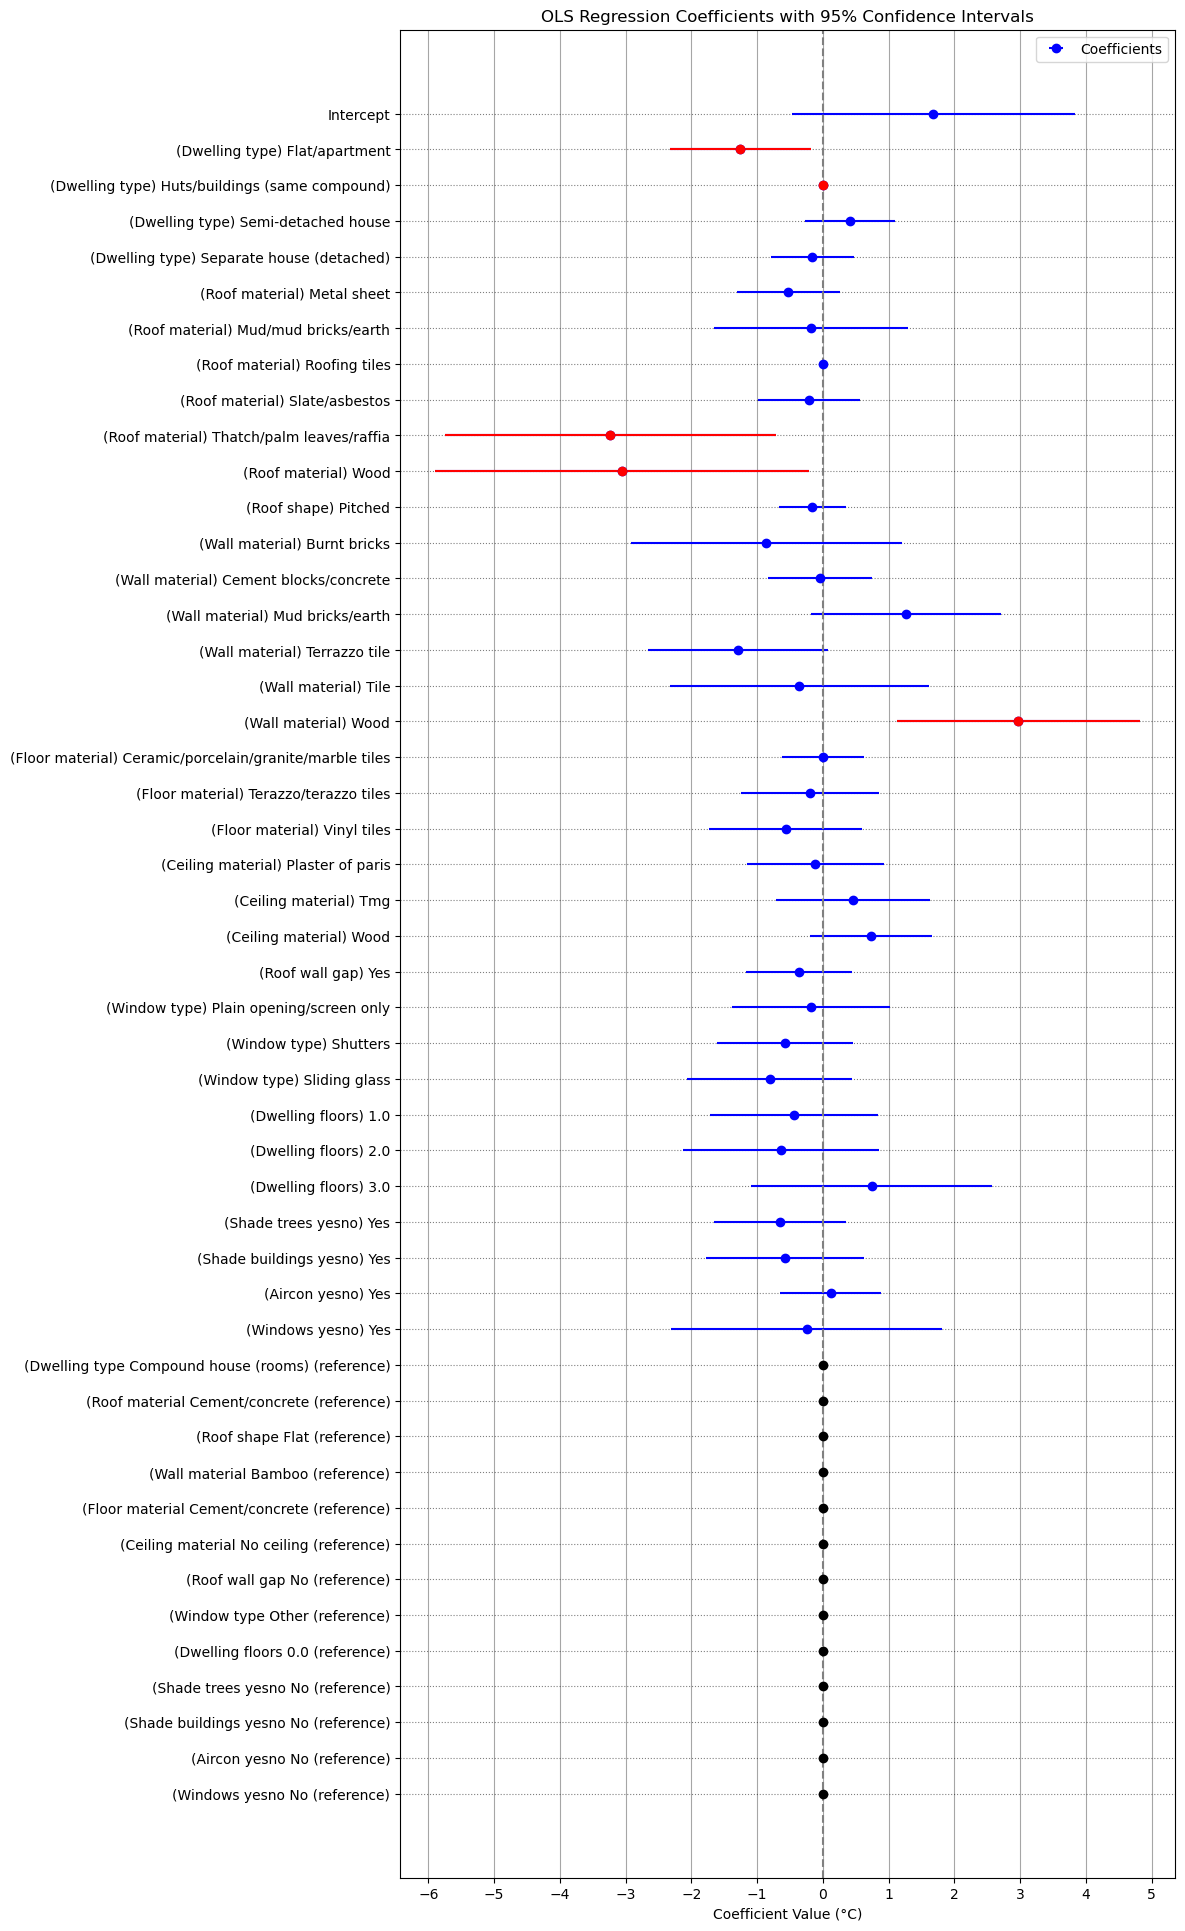

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting coefficients, standard errors, and confidence intervals
coefficients = results.params
standard_errors = results.bse
confidence_intervals = results.conf_int()

# Determining significance (p-value < 0.05)
p_values = results.pvalues
significant = p_values < 0.05

# Preparing data for plotting
variables = coefficients.index
y_pos = np.arange(len(variables))
lower_errors = coefficients - confidence_intervals[0]
upper_errors = confidence_intervals[1] - coefficients
errors = np.array([lower_errors, upper_errors])  # upper and lower errors

# Formatting variable names
formatted_variables = [format_variable_name(var) for var in variables]

# Adding reference categories and their positions
ref_categories = [format_variable_name(f"{variable.capitalize()}: {merged_df[variable].dropna().sort_values().unique()[0]} (Reference)") for variable in reg_variables]
ref_y_pos = np.arange(len(variables), len(variables) + len(ref_categories))
formatted_variables += ref_categories

# Creating the plot
plt.figure(figsize=(10, len(formatted_variables)/2))
plt.errorbar(coefficients, y_pos, xerr=errors, fmt='o', color='b', label='Coefficients')
plt.axvline(x=0, color='grey', linestyle='--')

# Highlighting significant coefficients
for i, sig in enumerate(significant):
    if sig:
        plt.errorbar(coefficients[i], y_pos[i], xerr=[[lower_errors[i]], [upper_errors[i]]], fmt='o', color='r')

# Plotting reference categories at 0 line
plt.plot([0] * len(ref_categories), ref_y_pos, 'ko')

# Adding labels and title
plt.yticks(np.arange(len(formatted_variables)), formatted_variables)
plt.xlabel('Coefficient Value (°C)')
plt.title('OLS Regression Coefficients with 95% Confidence Intervals')

# Adding grid lines for better readability
plt.grid(axis='x', linestyle='-', alpha=0.7, which='major', color='grey')
plt.grid(axis='y', linestyle=':', alpha=0.5, which='major', color='black')

# Set x-axis ticks at 1°C increments
plt.xticks(np.arange(np.floor(min(coefficients)) - 2, np.ceil(max(coefficients)) + 3, 1.0))

# Adding a legend
plt.legend(loc='best')

plt.gca().invert_yaxis()  # Optional: Invert y-axis so top is first variable
plt.savefig('coefficients.png', bbox_inches='tight')



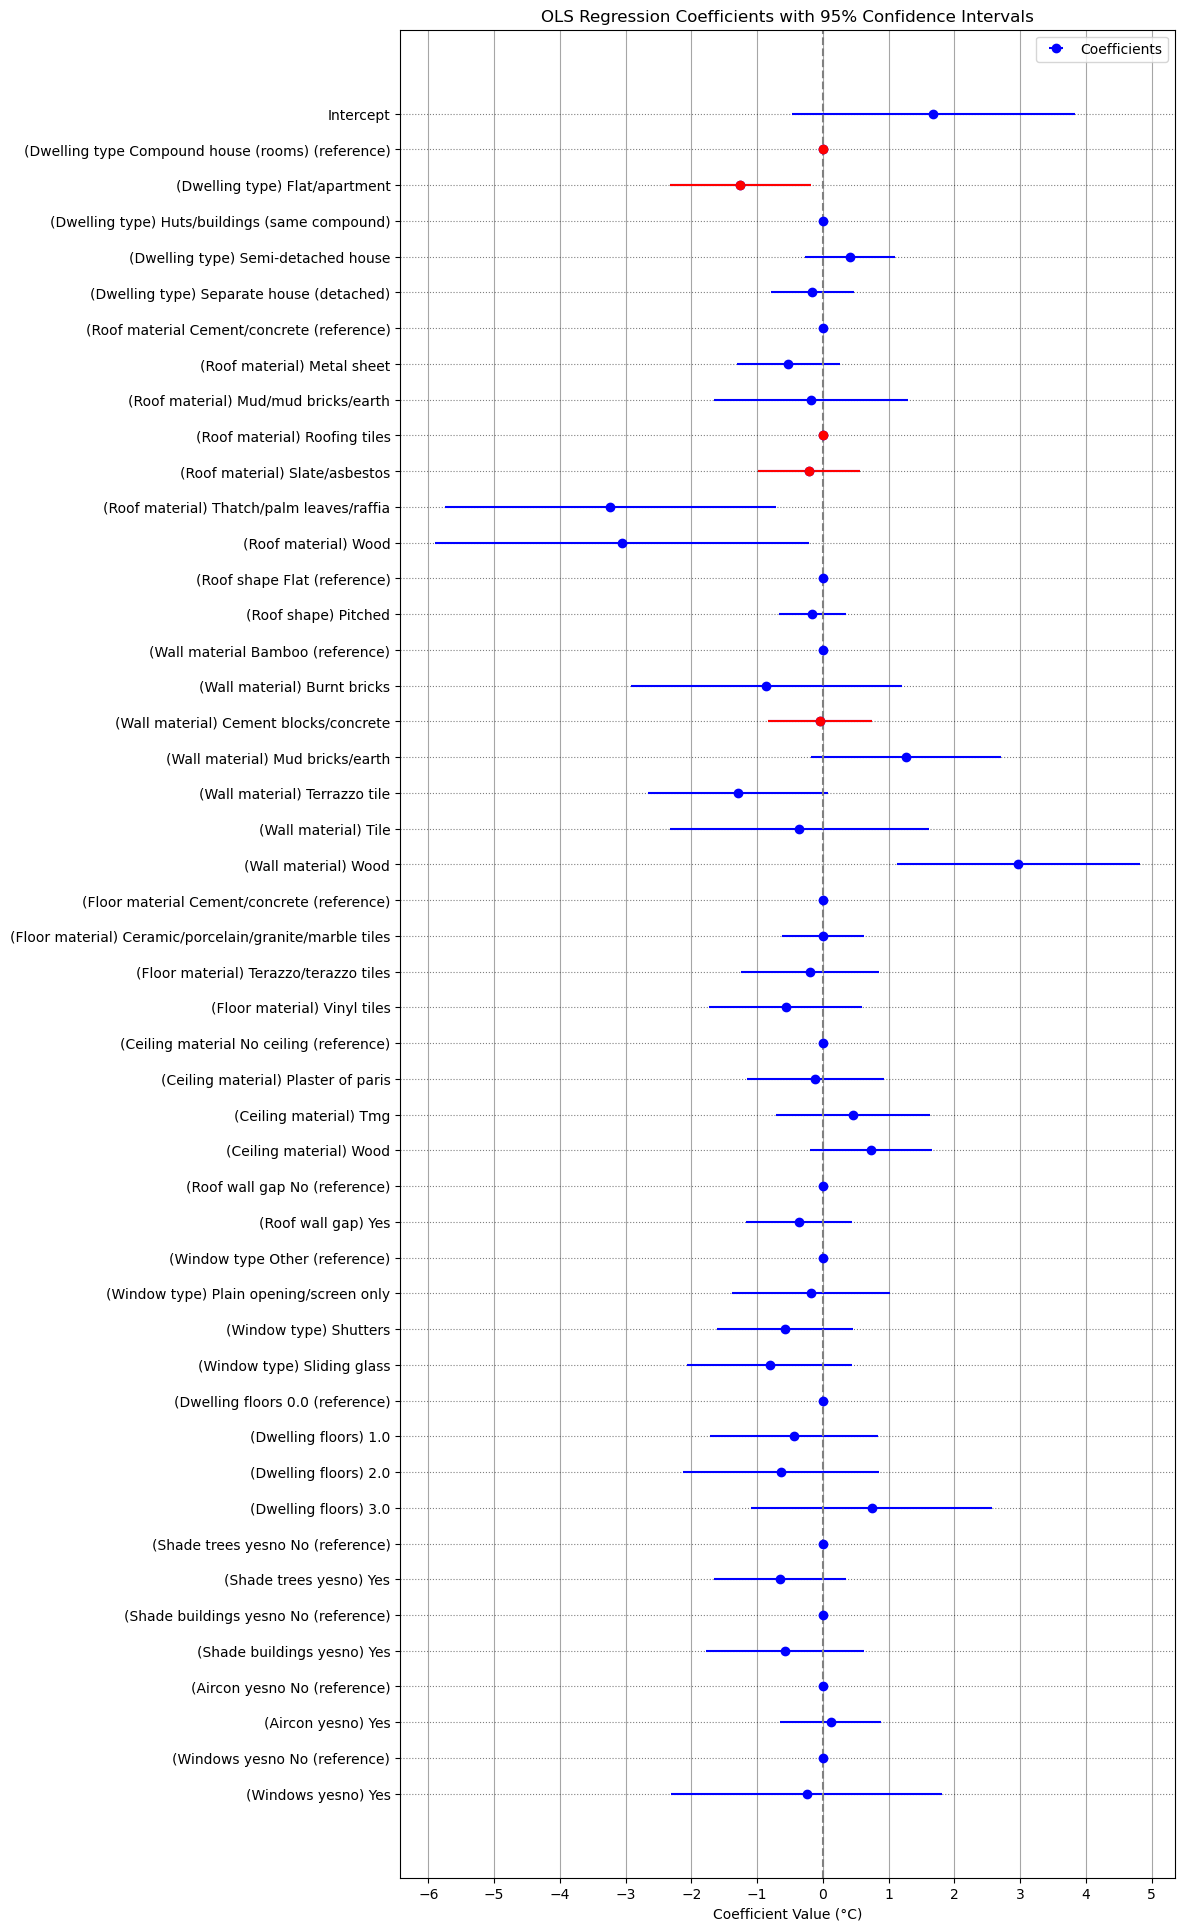

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting coefficients, standard errors, and confidence intervals
coefficients = results.params
standard_errors = results.bse
confidence_intervals = results.conf_int()

# Determining significance (p-value < 0.05)
p_values = results.pvalues
significant = p_values < 0.05

# Initializing arrays to store formatted variables, coefficients, and errors
formatted_variables = []
y_positions = []
coeff_values = []
errors = []

# Adding the intercept
formatted_variables.append('Intercept')
y_positions.append(len(y_positions))
coeff_values.append(coefficients['Intercept'])
errors.append([coefficients['Intercept'] - confidence_intervals.loc['Intercept', 0], 
               confidence_intervals.loc['Intercept', 1] - coefficients['Intercept']])

# Process each categorical variable and its reference
for variable in reg_variables:
    # Add the reference category first
    ref_category_name = format_variable_name(f"{variable.capitalize()}: {merged_df[variable].dropna().sort_values().unique()[0]} (Reference)")
    formatted_variables.append(ref_category_name)
    y_positions.append(len(y_positions))
    coeff_values.append(0)  # Reference categories have a coefficient of 0
    errors.append([0, 0])  # No error for reference categories

    # Now add the coefficients related to this variable
    for var in coefficients.index:
        if var.startswith(f'C({variable})['):
            formatted_variables.append(format_variable_name(var))
            y_positions.append(len(y_positions))
            coeff_values.append(coefficients[var])
            lower_error = coefficients[var] - confidence_intervals.loc[var, 0]
            upper_error = confidence_intervals.loc[var, 1] - coefficients[var]
            errors.append([lower_error, upper_error])

# Convert errors to numpy array for plotting
errors = np.array(errors).T

# Creating the plot
plt.figure(figsize=(10, len(formatted_variables)/2))
plt.errorbar(coeff_values, y_positions, xerr=errors, fmt='o', color='b', label='Coefficients')
plt.axvline(x=0, color='grey', linestyle='--')

# Highlighting significant coefficients
for i, sig in enumerate(significant):
    if sig and formatted_variables[i] != 'Intercept':
        plt.errorbar(coeff_values[i], y_positions[i], xerr=[[errors[0, i]], [errors[1, i]]], fmt='o', color='r')

# Adding labels and title
plt.yticks(y_positions, formatted_variables)
plt.xlabel('Coefficient Value (°C)')
plt.title('OLS Regression Coefficients with 95% Confidence Intervals')

# Adding grid lines for better readability
plt.grid(axis='x', linestyle='-', alpha=0.7, which='major', color='grey')
plt.grid(axis='y', linestyle=':', alpha=0.5, which='major', color='black')

# Set x-axis ticks at 1°C increments
plt.xticks(np.arange(np.floor(min(coeff_values)) - 2, np.ceil(max(coeff_values)) + 3, 1.0))

# Adding a legend
plt.legend(loc='best')

plt.gca().invert_yaxis()  # Optional: Invert y-axis so top is first variable
plt.savefig('coefficients.png', bbox_inches='tight')
